In [1]:
# 모듈 임포트
import warnings
warnings.filterwarnings('ignore')
import os
import json

import pandas as pd
import numpy as np
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, OneHotEncoder, StandardScaler

In [2]:
plt.rcParams["figure.figsize"] = (16,10) 
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.color'] = 'r' 
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

---
# 용인시 전기차 입지분석 및 지수 개발
---





## 데이터 로드 및 명세서 기준 컬럼명 변경

In [3]:
# load csv1
df1 = pd.read_csv('./data/1.ev_app_resident.csv')

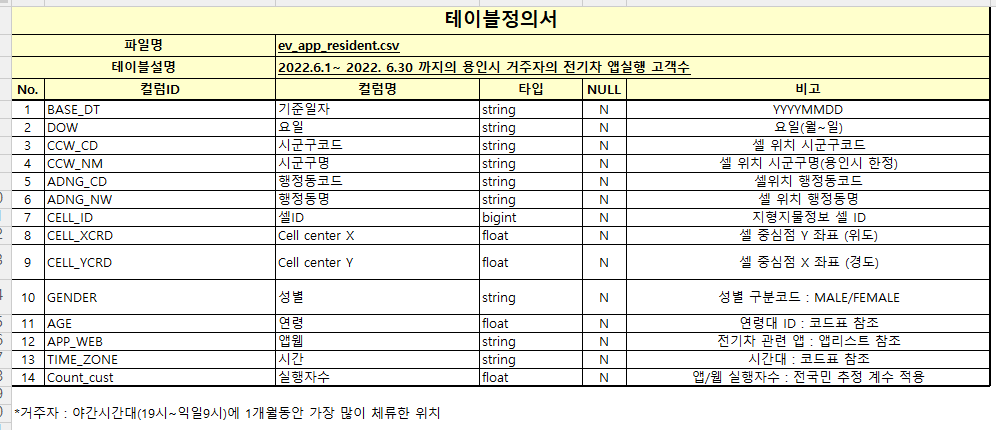

In [4]:
# 컬럼명 한글변환
df1.columns = ["기준일자" , "요일" , "시도명" , "시군구명" , "행정동코드" , 
               "행정동명" , "셀ID" , "경도" , "위도" , "성별" , 
               "연령" , "앱종류" , "앱실행시간대" , "실행자수" ]

In [5]:
df1.drop(['셀ID','행정동코드'], axis = 1, inplace = True)

In [6]:
df1.시도명 = df1.시도명.apply(lambda x : str(x).replace('4146', '경기도'))

In [7]:
df1['group'] = 1
df1

기준일자  요일  시도명 시군구명   행정동명          경도         위도      성별  연령  \
0       20220605   7  경기도  용인시   동백1동  127.152250  37.286300    MALE   6   
1       20220625   6  경기도  용인시   상현2동  127.090080  37.309536    MALE   8   
2       20220614   2  경기도  용인시    포곡읍  127.216600  37.274303  FEMALE  14   
3       20220619   7  경기도  용인시    신봉동  127.080970  37.323480    MALE  13   
4       20220624   5  경기도  용인시   상현2동  127.091780  37.306840    MALE   8   
...          ...  ..  ...  ...    ...         ...        ...     ...  ..   
292038  20220605   7  경기도  용인시   상현1동  127.079384  37.304993    MALE   2   
292039  20220607   2  경기도  용인시    중앙동  127.193080  37.234580    MALE   3   
292040  20220611   6  경기도  용인시    남사읍  127.170300  37.156097    MALE  13   
292041  20220618   6  경기도  용인시    양지면  127.286095  37.230280    MALE   9   
292042  20220618   6  경기도  용인시  풍덕천1동  127.088860  37.326210    MALE   9   

           앱종류  앱실행시간대    실행자수  group  
0        EV라운지       5   3.522      1  
1       파워큐브차저       2   4.231      1  
2        EV라운지       1  18.440      1  
3        EV라운지       2   4.335      1  
4        EV라운지       4   4.231      1  
...        ...     ...     ...    ...  
292038   EV라운지       3   5.082      1  
292039   EV라운지       6   4.585      1  
292040   EV라운지       2   6.452      1  
292041   EV라운지       6   3.071      1  
292042    하이차저       2   3.667      1  

[292043 rows x 13 columns]

In [8]:
# load csv 2
df2 = pd.read_csv('./data/2.ev_app_activity.csv')

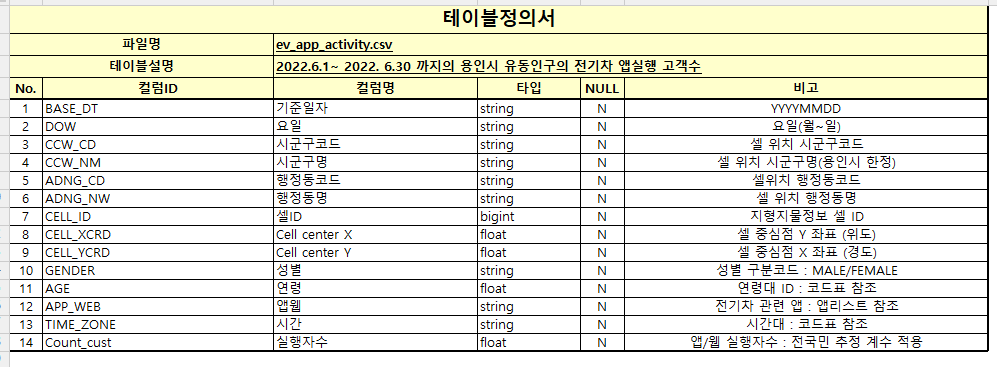

"	기준일자	"	,
"	요일	"	,
"	시군구코드	"	,
"	시군구명	"	,
"	행정동코드	"	,
"	행정동명	"	,
"	셀ID	"	,
"	Cell center X	"	,
"	Cell center Y	"	,
"	성별	"	,
"	연령	"	,
"	앱웹	"	,
"	시간	"	,
"	실행자수	"	


In [9]:
# 컬럼명 한글변환
df2.columns = ["기준일자" , "요일" , "시도명" , "시군구명" , "행정동코드" , 
               "행정동명" , "셀ID" , "경도" , "위도" , "성별" , 
               "연령" , "앱종류" , "앱실행시간대" , "실행자수"]

In [10]:
df2.drop(['셀ID','행정동코드'], axis = 1, inplace = True)
df2.시도명 = df2.시도명.apply(lambda x : str(x).replace('4146', '경기도'))

In [11]:
df2['group'] = 2
df2

기준일자  요일  시도명 시군구명  행정동명          경도         위도      성별  연령  \
0       20220614   2  경기도  용인시   이동읍  127.216920  37.188220    MALE  12   
1       20220613   1  경기도  용인시   마북동  127.127350  37.303352    MALE  14   
2       20220602   4  경기도  용인시  동백2동  127.154590  37.268280    MALE  14   
3       20220606   1  경기도  용인시   남사읍  127.178110  37.174600    MALE   9   
4       20220608   3  경기도  용인시  죽전1동  127.117645  37.325855  FEMALE  10   
...          ...  ..  ...  ...   ...         ...        ...     ...  ..   
264708  20220621   2  경기도  용인시   모현읍  127.148200  37.308372    MALE   7   
264709  20220628   2  경기도  용인시   신봉동  127.080400  37.324825    MALE   3   
264710  20220626   7  경기도  용인시   신갈동  127.090180  37.290607    MALE  12   
264711  20220620   1  경기도  용인시   성복동  127.073105  37.318040    MALE  14   
264712  20220601   3  경기도  용인시   구갈동  127.116196  37.277176    MALE   7   

          앱종류  앱실행시간대    실행자수  group  
0       EV라운지       4   3.829      2  
1       EV라운지       1   9.994      2  
2       EV라운지       4   7.502      2  
3       EV라운지       4   3.234      2  
4       EV라운지       5   3.315      2  
...       ...     ...     ...    ...  
264708  EV라운지       2   7.140      2  
264709  EV라운지       5  21.564      2  
264710  EV라운지       4   3.502      2  
264711  EV라운지       3  11.406      2  
264712  EV라운지       4   3.411      2  

[264713 rows x 13 columns]

In [12]:
# load csv3
df3 = pd.read_csv('./data/3.ev_app_activity_resident.csv')

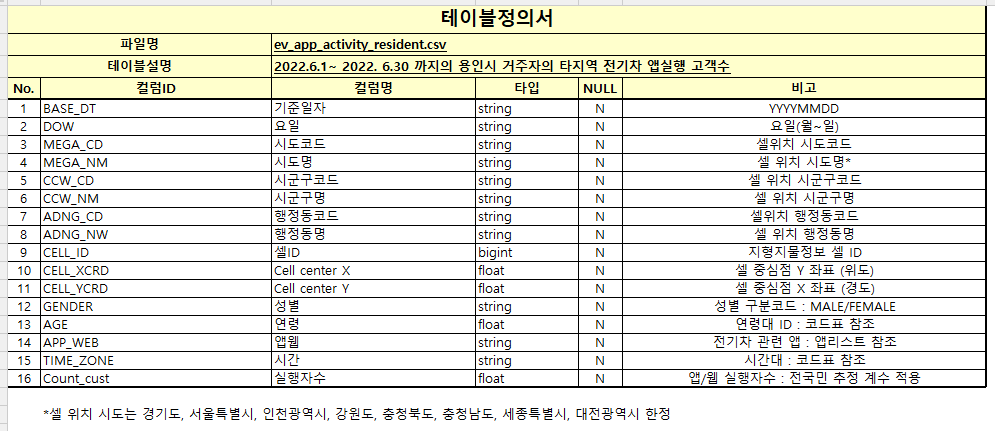

In [13]:
# 컬럼명 한글변환
df3.columns = ["기준일자" , "요일" , "시도코드" , "시도명" , "시군구코드" , "시군구명" ,
               "행정동코드" , "행정동명" , "셀ID" , "경도" , "위도" ,
               "성별" , "연령" , "앱종류" , "앱실행시간대" , "실행자수"]

In [14]:
df3.drop(['셀ID','시도코드','시군구코드','행정동코드'], axis = 1, inplace = True)

In [15]:
df3['group'] = 3
df3

기준일자  요일    시도명 시군구명    행정동명          경도         위도      성별  연령  \
0       20220611   6    경기도  용인시     모현읍  127.171880  37.311146  FEMALE  13   
1       20220605   7  서울특별시  강남구    삼성1동  127.061264  37.509087    MALE   6   
2       20220602   4  서울특별시  성동구  성수2가1동  127.056560  37.540170    MALE  10   
3       20220608   3    경기도  용인시     신갈동  127.110490  37.290226  FEMALE  13   
4       20220608   3    경기도  이천시     호법면  127.386450  37.213290    MALE  11   
...          ...  ..    ...  ...     ...         ...        ...     ...  ..   
293166  20220609   4    경기도  용인시     신봉동  127.074730  37.329315  FEMALE  11   
293167  20220626   7    경기도  용인시    죽전1동  127.137360  37.333126    MALE   8   
293168  20220607   2    경기도  성남시     위례동  127.141785  37.471504    MALE  10   
293169  20220619   7  서울특별시  강남구    역삼1동  127.033035  37.499966    MALE   8   
293170  20220605   7    경기도  용인시    영덕1동  127.072790  37.272970  FEMALE  13   

          앱종류  앱실행시간대    실행자수  group  
0       EV라운지       1   4.492      3  
1       EV라운지       4   3.666      3  
2       EV라운지       4   3.247      3  
3       EV라운지       3   6.664      3  
4       EV라운지       5   3.945      3  
...       ...     ...     ...    ...  
293166  EV라운지       3   3.396      3  
293167  EV라운지       6   4.320      3  
293168  EV라운지       4  11.457      3  
293169   하이차저       5   4.232      3  
293170  EV라운지       2   5.716      3  

[293171 rows x 13 columns]

In [16]:
# 확인
df1.shape, df2.shape, df3.shape

((292043, 13), (264713, 13), (293171, 13))

In [17]:
#컬럼명 확인
df1.columns, df2.columns, df3.columns

(Index(['기준일자', '요일', '시도명', '시군구명', '행정동명', '경도', '위도', '성별', '연령', '앱종류',
        '앱실행시간대', '실행자수', 'group'],
       dtype='object'),
 Index(['기준일자', '요일', '시도명', '시군구명', '행정동명', '경도', '위도', '성별', '연령', '앱종류',
        '앱실행시간대', '실행자수', 'group'],
       dtype='object'),
 Index(['기준일자', '요일', '시도명', '시군구명', '행정동명', '경도', '위도', '성별', '연령', '앱종류',
        '앱실행시간대', '실행자수', 'group'],
       dtype='object'))

In [18]:
# 요일변환
weekday_list = ['월', '화', '수', '목', '금', '토', '일']
df1.요일 = df1.요일.apply(lambda x : weekday_list[x-1])
df2.요일 = df2.요일.apply(lambda x : weekday_list[x-1])
df3.요일 = df3.요일.apply(lambda x : weekday_list[x-1])

In [19]:
# 나이 변환
age_list = [" 10세미만 " , " 10세이상-15세미만 " , " 15세이상-20세미만 " , " 20세이상-25세미만 " , " 25세이상-30세미만 ", 
            " 30세이상-35세미만 " , " 35세이상-40세미만 " , " 40세이상-45세미만 " , " 45세이상-50세미만 " ,
            " 50세이상-55세미만 " , " 55세이상-60세미만 " , " 60세이상-66세미만 " , " 66세이상-70세미만 " , " 70세 이상 "]

df1.연령 = df1.연령.apply(lambda x : age_list[x-1])
df2.연령 = df2.연령.apply(lambda x : age_list[x-1])
df3.연령 = df3.연령.apply(lambda x : age_list[x-1])

In [20]:
# 시간
time_list = ["0시-6시" , "6시-9시" , "9시-12시" , "12시-18시" , "18시-21시" , "21시-24시"]

df1.앱실행시간대 = df1.앱실행시간대.apply(lambda x : time_list[x-1])
df2.앱실행시간대 = df2.앱실행시간대.apply(lambda x : time_list[x-1])
df3.앱실행시간대 = df3.앱실행시간대.apply(lambda x : time_list[x-1])

In [21]:
# 확인
df1.head(2), df2.head(2), df2.head(2)

(       기준일자 요일  시도명 시군구명  행정동명         경도         위도    성별             연령  \
 0  20220605  일  경기도  용인시  동백1동  127.15225  37.286300  MALE   30세이상-35세미만    
 1  20220625  토  경기도  용인시  상현2동  127.09008  37.309536  MALE   40세이상-45세미만    
 
       앱종류   앱실행시간대   실행자수  group  
 0   EV라운지  18시-21시  3.522      1  
 1  파워큐브차저    6시-9시  4.231      1  ,
        기준일자 요일  시도명 시군구명 행정동명         경도         위도    성별             연령  \
 0  20220614  화  경기도  용인시  이동읍  127.21692  37.188220  MALE   60세이상-66세미만    
 1  20220613  월  경기도  용인시  마북동  127.12735  37.303352  MALE        70세 이상    
 
      앱종류   앱실행시간대   실행자수  group  
 0  EV라운지  12시-18시  3.829      2  
 1  EV라운지    0시-6시  9.994      2  ,
        기준일자 요일  시도명 시군구명 행정동명         경도         위도    성별             연령  \
 0  20220614  화  경기도  용인시  이동읍  127.21692  37.188220  MALE   60세이상-66세미만    
 1  20220613  월  경기도  용인시  마북동  127.12735  37.303352  MALE        70세 이상    
 
      앱종류   앱실행시간대   실행자수  group  
 0  EV라운지  12시-18시  3.829      2  
 1  EV라운지    

---
## 자료형태확인
---

1. 용인시 거주자의 전기차 충전 앱 실행 292043 rows × 14 columns
2. 용인시 유동인구의 전기차 충전 앱 실행 264713 rows × 14 columns
3. 용인시 거주자의 타지역 충전 앱 실행 293171 rows × 16 columns



In [22]:
# 결측치 확인
pd.DataFrame([df1.isna().sum(), df2.isna().sum(), df3.isna().sum()])

기준일자  요일  시도명  시군구명  행정동명  경도  위도  성별  연령  앱종류  앱실행시간대  실행자수  group
0     0   0    0     0     0   0   0   0   0    0       0     0      0
1     0   0    0     0     0   0   0   0   0    0       0     0      0
2     0   0    0     0     0   0   0   0   0    0       0     0      0

---
## 데이터 병합
---

In [23]:
# 총 개수 확인
print(len(df1), len(df2), len(df3), ' = ' , len(df1) + len(df2)+ len(df3))

292043 264713 293171  =  849927


In [24]:
# 병합
df_sum = pd.concat([df1, df2, df3], join = 'outer', axis = 0)

In [25]:
len(df_sum)

849927

In [26]:
# 병합확인
df_sum.tail(2)

기준일자 요일    시도명 시군구명  행정동명          경도         위도      성별  \
293169  20220619  일  서울특별시  강남구  역삼1동  127.033035  37.499966    MALE   
293170  20220605  일    경기도  용인시  영덕1동  127.072790  37.272970  FEMALE   

                   연령    앱종류   앱실행시간대   실행자수  group  
293169   40세이상-45세미만    하이차저  18시-21시  4.232      3  
293170   66세이상-70세미만   EV라운지    6시-9시  5.716      3

In [27]:
df_sum.shape

(849927, 13)

In [28]:
# 실행자수 소수점 제거.
df_sum.실행자수 = df_sum.실행자수.apply(lambda x : int(x))

In [29]:
# 인덱스 초기화
df_sum.reset_index(drop = True, inplace = True)

---
## 용인시 전기차 충전소 현황 데이터 확인
---
- 한국환경공단_전기자동차 충전소 정보 // Open API에서 데이터 수집

In [30]:
yong_elc = pd.read_csv('./data/outside/yong_elec.csv')
yong_elc.head()

Unnamed: 0         충전소명     충전소ID  충전기ID  충전기타입  \
0           0         용인시청  ME174147      1      6   
1           1       포곡읍사무소  ME174148      1      6   
2           2  죽전휴게소(서울방향)  ME178002      1      6   
3           3  죽전휴게소(서울방향)  ME178002      2      6   
4           4  기흥휴게소(부산방향)  ME178003      1      6   

                             주소 상세위치     이용가능시간         위도          경도  ...  \
0           경기도 용인시 처인구 삼가동 556  NaN  24시간 이용가능  37.240666  127.177375  ...   
1       경기도 용인시 처인구 포곡읍 포곡로 258  NaN  24시간 이용가능  37.278100  127.231259  ...   
2  경기도 용인시 수지구 경부고속도로 400 (죽전동)  NaN  24시간 이용가능  37.332073  127.104848  ...   
3  경기도 용인시 수지구 경부고속도로 400 (죽전동)  NaN  24시간 이용가능  37.332073  127.104848  ...   
4     경기도 용인시 기흥구 공세로 173 (공세동)  NaN  24시간 이용가능  37.235656  127.105021  ...   

  지역코드 지역구분 상세 코드 충전소 구분 코드 충전소 구분 상세코드  주차료무료  충전소 안내  이용자 제한  이용제한 사유  \
0   41      41460        A0        A001      N     NaN       N      NaN   
1   41      41460        A0        A002      N     NaN       N      NaN   
2   41      41460        C0        C001      Y     NaN       N      NaN   
3   41      41460        C0        C001      Y     NaN       N      NaN   
4   41      41460        C0        C001      Y     NaN       N      NaN   

   삭제 여부  삭제 사유  
0      N    NaN  
1      N    NaN  
2      N    NaN  
3      N    NaN  
4      N    NaN  

[5 rows x 32 columns]

In [31]:
# 결측치 확인
yong_elc.isna().sum()

Unnamed: 0        0
충전소명              0
충전소ID             0
충전기ID             0
충전기타입             0
주소                4
상세위치           2210
이용가능시간          113
위도                0
경도                0
기관 아이디            0
기관명               0
운영기관명             0
운영기관연락처         116
충전기상태             0
상태갱신일시          193
마지막 충전시작일시     1489
마지막 충전종료일시     1476
충전중 시작일시       1607
파워타입           4457
충전용량           1523
충전방식           1405
지역코드              0
지역구분 상세 코드        0
충전소 구분 코드        19
충전소 구분 상세코드      19
주차료무료            10
충전소 안내         3541
이용자 제한            0
이용제한 사유        1581
삭제 여부             0
삭제 사유          4457
dtype: int64

In [32]:
yong_elc.columns

Index(['Unnamed: 0', '충전소명', '충전소ID', '충전기ID', '충전기타입', '주소', '상세위치', '이용가능시간',
       '위도', '경도', '기관 아이디', '기관명', '운영기관명', '운영기관연락처', '충전기상태', '상태갱신일시',
       '마지막 충전시작일시', '마지막 충전종료일시', '충전중 시작일시', '파워타입', '충전용량', '충전방식', '지역코드',
       '지역구분 상세 코드', '충전소 구분 코드', '충전소 구분 상세코드', '주차료무료', '충전소 안내', '이용자 제한',
       '이용제한 사유', '삭제 여부', '삭제 사유'],
      dtype='object')

In [33]:
# 1차 삭제할 컬럼 : 
# ['Unnamed']: 0 : 불필요
# ['삭제사유, 파워타입'] : 전체공백, 
# ['주소', '상세위치', '지역코드', '지역구분 상세코드'] : d/t 위경도 exist

yong_elc.drop(['Unnamed: 0', '지역코드', '지역구분 상세 코드', '상세위치', 
               '주소', '삭제 사유', '파워타입', ], axis = 1, inplace = True)
yong_elc.head(5)

충전소명     충전소ID  충전기ID  충전기타입     이용가능시간         위도          경도  \
0         용인시청  ME174147      1      6  24시간 이용가능  37.240666  127.177375   
1       포곡읍사무소  ME174148      1      6  24시간 이용가능  37.278100  127.231259   
2  죽전휴게소(서울방향)  ME178002      1      6  24시간 이용가능  37.332073  127.104848   
3  죽전휴게소(서울방향)  ME178002      2      6  24시간 이용가능  37.332073  127.104848   
4  기흥휴게소(부산방향)  ME178003      1      6  24시간 이용가능  37.235656  127.105021   

  기관 아이디  기관명 운영기관명  ...      충전중 시작일시  충전용량  충전방식  충전소 구분 코드  충전소 구분 상세코드  \
0     ME  환경부   환경부  ...           NaN  50.0    단독         A0         A001   
1     ME  환경부   환경부  ...           NaN  50.0    단독         A0         A002   
2     ME  환경부   환경부  ...           NaN  50.0    단독         C0         C001   
3     ME  환경부   환경부  ...  2.022101e+13  50.0    단독         C0         C001   
4     ME  환경부   환경부  ...           NaN  50.0    단독         C0         C001   

   주차료무료  충전소 안내 이용자 제한 이용제한 사유 삭제 여부  
0      N     NaN      N     NaN     N  
1      N     NaN      N     NaN     N  
2      Y     NaN      N     NaN     N  
3      Y     NaN      N     NaN     N  
4      Y     NaN      N     NaN     N  

[5 rows x 25 columns]

In [34]:
# 결측치 재확인
yong_elc.isna().sum()

충전소명              0
충전소ID             0
충전기ID             0
충전기타입             0
이용가능시간          113
위도                0
경도                0
기관 아이디            0
기관명               0
운영기관명             0
운영기관연락처         116
충전기상태             0
상태갱신일시          193
마지막 충전시작일시     1489
마지막 충전종료일시     1476
충전중 시작일시       1607
충전용량           1523
충전방식           1405
충전소 구분 코드        19
충전소 구분 상세코드      19
주차료무료            10
충전소 안내         3541
이용자 제한            0
이용제한 사유        1581
삭제 여부             0
dtype: int64

In [35]:
# 이용제한 사유
yong_elc[yong_elc['이용제한 사유'].notna()]['이용제한 사유'].value_counts().head(5)
yong_elc.drop('이용제한 사유', axis = 1, inplace = True)

In [36]:
# 충전소 안내
yong_elc[yong_elc['충전소 안내'].notna()]['충전소 안내'].value_counts().head(5)
yong_elc.drop('충전소 안내', axis = 1, inplace = True)

In [37]:
# 주차료 무료 확인
# 살릴 칼럼. 결측치 확인
yong_elc[yong_elc['주차료무료'].notna()].주차료무료.value_counts()

Y    3391
N    1056
Name: 주차료무료, dtype: int64

In [38]:
# 이마트 
yong_elc[yong_elc['주차료무료'].isna()].충전소명.value_counts()

용인시 이마트(수지점)      2
용인시 이마트(죽전점)      2
용인시 이마트(용인점)      2
용인시 이마트(보라점)      2
용인시 이마트TR(구성점)    2
Name: 충전소명, dtype: int64

In [39]:
# 이마트 동백점을 제외하고 전부 주차료 유료. > 결측치 N(유료)로 대체
yong_elc.query('충전소명.str.contains("이마트")').주차료무료.value_counts()

N    22
Y     1
Name: 주차료무료, dtype: int64

In [40]:
# 채우기
yong_elc.주차료무료.fillna('N', inplace = True)

In [41]:
# 결측치 재확인
yong_elc.isna().sum(), yong_elc.head(3)

(충전소명              0
 충전소ID             0
 충전기ID             0
 충전기타입             0
 이용가능시간          113
 위도                0
 경도                0
 기관 아이디            0
 기관명               0
 운영기관명             0
 운영기관연락처         116
 충전기상태             0
 상태갱신일시          193
 마지막 충전시작일시     1489
 마지막 충전종료일시     1476
 충전중 시작일시       1607
 충전용량           1523
 충전방식           1405
 충전소 구분 코드        19
 충전소 구분 상세코드      19
 주차료무료             0
 이용자 제한            0
 삭제 여부             0
 dtype: int64,
           충전소명     충전소ID  충전기ID  충전기타입     이용가능시간         위도          경도  \
 0         용인시청  ME174147      1      6  24시간 이용가능  37.240666  127.177375   
 1       포곡읍사무소  ME174148      1      6  24시간 이용가능  37.278100  127.231259   
 2  죽전휴게소(서울방향)  ME178002      1      6  24시간 이용가능  37.332073  127.104848   
 
   기관 아이디  기관명 운영기관명  ...    마지막 충전시작일시    마지막 충전종료일시  충전중 시작일시  충전용량  충전방식  \
 0     ME  환경부   환경부  ...  2.022101e+13  2.022101e+13       NaN  50.0    단독   
 1     ME  환경부   환경부  ...  2.02210

# 필요한 컬럼만 선별 후 저장

In [42]:
# 필요한 것만 가져오기
# 충전소명, 충전기타입, 위도, 경도, 충전용량, 충전방식, 주차료무료
yong_elc = yong_elc[['충전소명', '충전기타입', '위도', '경도', '충전용량', '충전방식', '주차료무료']]
yong_elc.head(3)

충전소명  충전기타입         위도          경도  충전용량 충전방식 주차료무료
0         용인시청      6  37.240666  127.177375  50.0   단독     N
1       포곡읍사무소      6  37.278100  127.231259  50.0   단독     N
2  죽전휴게소(서울방향)      6  37.332073  127.104848  50.0   단독     Y

- 충전기타입 (01:DC차데모, 02: AC완속, 03: DC차데모+AC3상, 04: DC콤보, 05: DC차데모+DC콤보 06: DC차데모+AC3상+DC콤보, 07: AC3상)
- 충전방식 (단독/동시)
- 충전용량 kW (3, 7, 50, 100, 200)

In [43]:
yong_elc.isna().sum()

충전소명        0
충전기타입       0
위도          0
경도          0
충전용량     1523
충전방식     1405
주차료무료       0
dtype: int64

In [44]:
yong_elc[yong_elc.충전용량.isna()].head(3)

충전소명  충전기타입         위도          경도  충전용량 충전방식 주차료무료
82         강남앤플러스      2  37.271026  127.126097   NaN  NaN     Y
83         강남앤플러스      2  37.271026  127.126097   NaN  NaN     Y
84  광교산 한양수자인더킨포크      2  37.334572  127.057609   NaN  NaN     Y

In [45]:
yong_elc[yong_elc.충전방식.isna()].head(3)

충전소명  충전기타입         위도          경도  충전용량 충전방식 주차료무료
82         강남앤플러스      2  37.271026  127.126097   NaN  NaN     Y
83         강남앤플러스      2  37.271026  127.126097   NaN  NaN     Y
84  광교산 한양수자인더킨포크      2  37.334572  127.057609   NaN  NaN     Y

In [46]:
# 결측치는 '미상' 으로 수정
yong_elc.fillna('0', axis = 1, inplace = True)

In [47]:
yong_elc.to_csv('./data/파생data/yongin_electro.csv')

---
## 데이터 분석
---
1. df_sum / 통합프레임
2. yong_elc / 전기차 충전소 프레임

In [48]:
df_sum.head(3)

기준일자 요일  시도명 시군구명  행정동명         경도         위도      성별             연령  \
0  20220605  일  경기도  용인시  동백1동  127.15225  37.286300    MALE   30세이상-35세미만    
1  20220625  토  경기도  용인시  상현2동  127.09008  37.309536    MALE   40세이상-45세미만    
2  20220614  화  경기도  용인시   포곡읍  127.21660  37.274303  FEMALE        70세 이상    

      앱종류   앱실행시간대  실행자수  group  
0   EV라운지  18시-21시     3      1  
1  파워큐브차저    6시-9시     4      1  
2   EV라운지    0시-6시    18      1

In [49]:
# 요일별 충전앱 실행 현황 비율
# 낮은 가중치
df_sum.요일.value_counts()

수    148651
목    141411
금    119601
화    119293
토    110572
월    109895
일    100504
Name: 요일, dtype: int64

In [50]:
df_sum.groupby('요일')[['시도명','시군구명','행정동명']].value_counts() / df_sum.shape[0] * 100

요일  시도명  시군구명  행정동명
금   경기도  용인시   죽전1동    0.549694
               모현읍     0.536164
               역삼동     0.529928
               구갈동     0.521457
               성복동     0.451098
                         ...   
화   강원도  원주시   봉산동     0.000118
               행구동     0.000118
         정선군   사북읍     0.000118
         철원군   근동면     0.000118
         춘천시   신사우동    0.000118
Length: 4824, dtype: float64

In [51]:
df_sum.groupby('요일')['연령'].value_counts() / df_sum.shape[0] * 100,1

(요일  연령           
 금    50세이상-55세미만     1.877926
      40세이상-45세미만     1.761445
      55세이상-60세미만     1.682144
      45세이상-50세미만     1.571076
      60세이상-66세미만     1.299053
                        ...   
 화    25세이상-30세미만     0.771360
      20세이상-25세미만     0.430743
      15세이상-20세미만     0.369561
      10세이상-15세미만     0.158720
      10세미만           0.010354
 Name: 연령, Length: 98, dtype: float64,
 1)

In [52]:
df_sum.groupby('요일')['앱종류'].value_counts() / df_sum.shape[0] * 100,1

(요일  앱종류     
 금   EV라운지       11.696299
     하이차저         2.034175
     G차저          0.080830
     파워큐브차저       0.075654
     EV Infra     0.075183
                   ...    
 화   일렉배리         0.007765
     채비           0.006001
     Epit         0.005648
     evWhere      0.000353
     테슬라          0.000353
 Name: 앱종류, Length: 104, dtype: float64,
 1)

In [84]:
# 타시도 실행을 제외한 일자별 실행 총합의 평균
a = int(df_sum.query('group != 3').groupby('기준일자')['실행자수'].sum().mean())
print(f' 일별 평균 앱실행수 : {a} 건')

 일별 평균 앱실행수 : 114520 건


---
## 차트 시각화
---

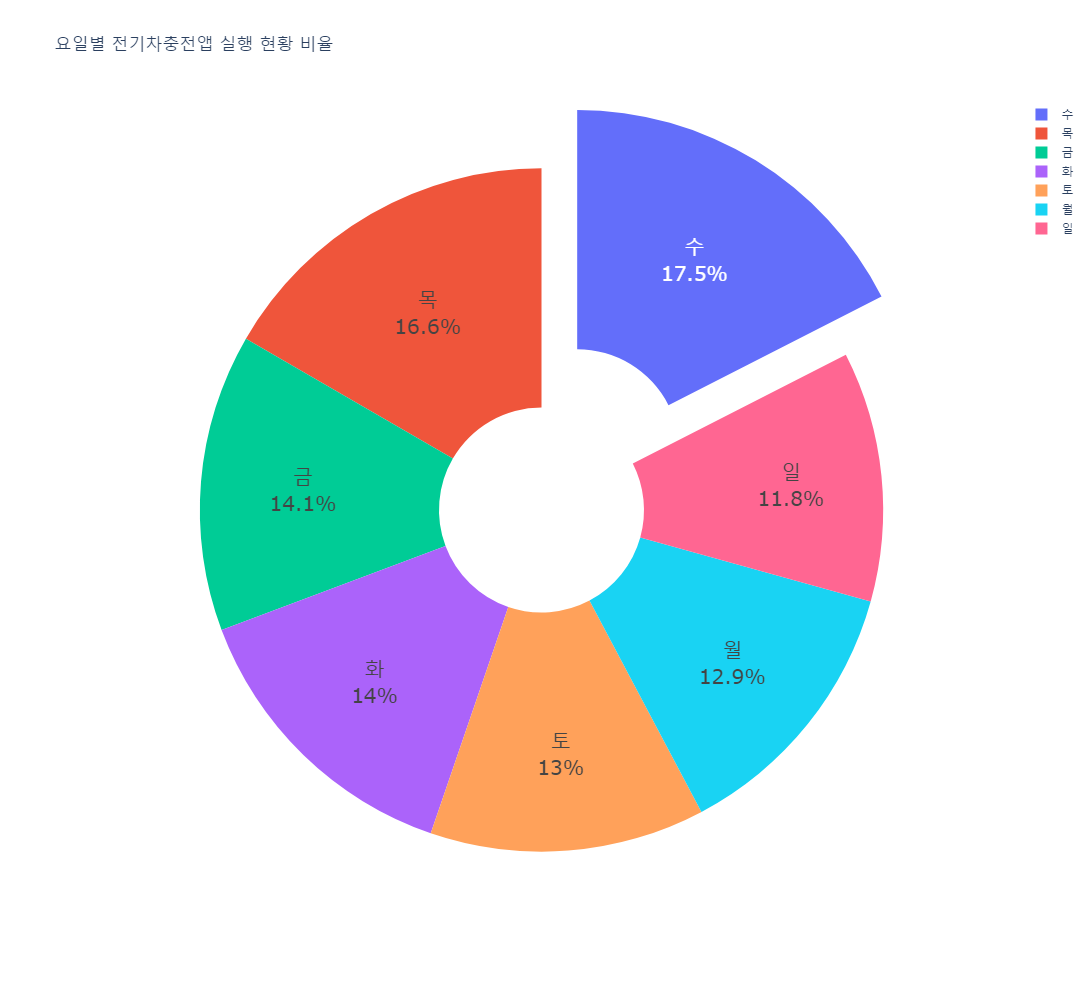

In [53]:
fig = px.pie(df_sum, values = df_sum.요일.value_counts(), 
             names = df_sum.요일.value_counts().index, hole=.3,
             title='요일별 전기차충전앱 실행 현황 비율',
             height = 1000, width = 800)

fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=20, pull=[0.2, 0, 0, 0])
fig.show()

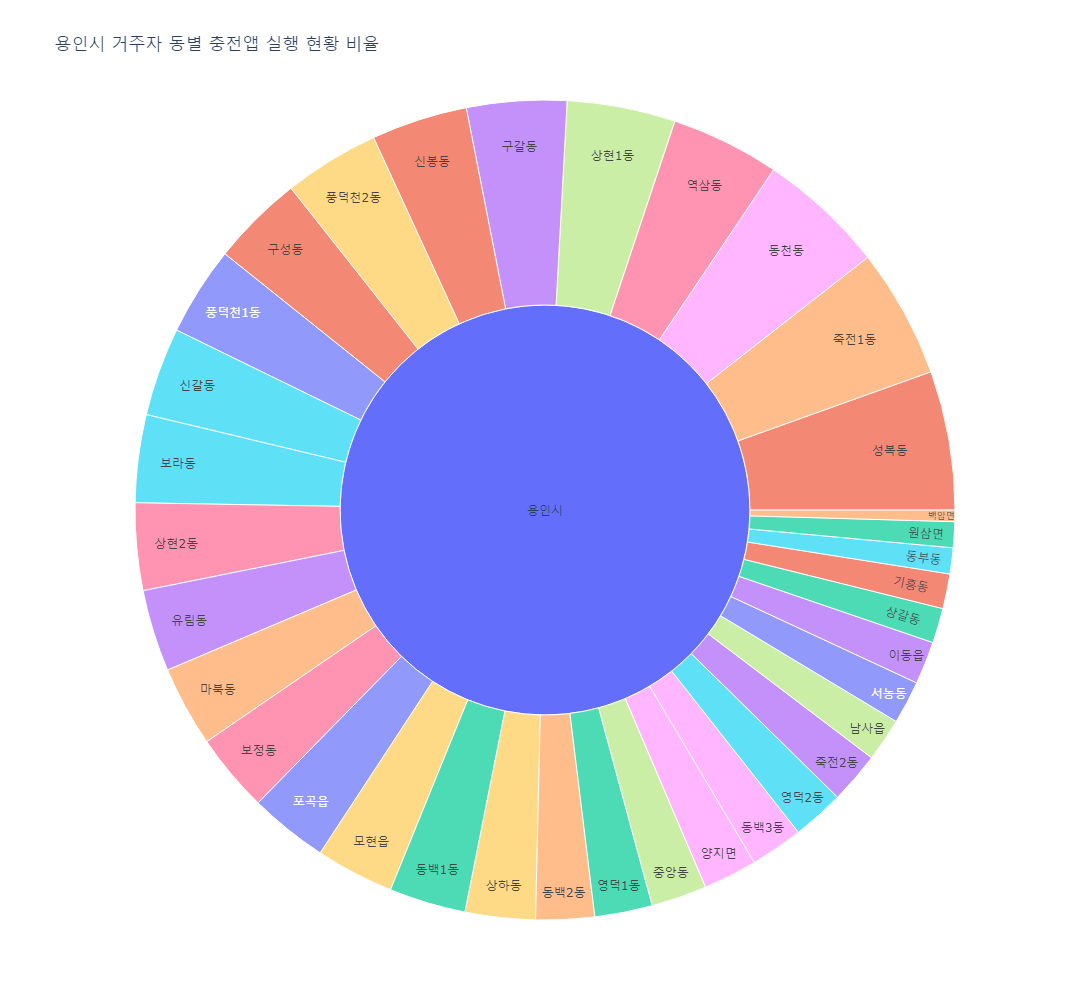

In [54]:
# 그룹1. 용인시 거주자 동별 충전앱 실행 현황 비율
fig = px.sunburst(df_sum[df_sum.group == 1], path=['시군구명','행정동명'], color='행정동명', values = '실행자수',
                  title='용인시 거주자 동별 충전앱 실행 현황 비율', height = 1000, width = 800)


fig.show()

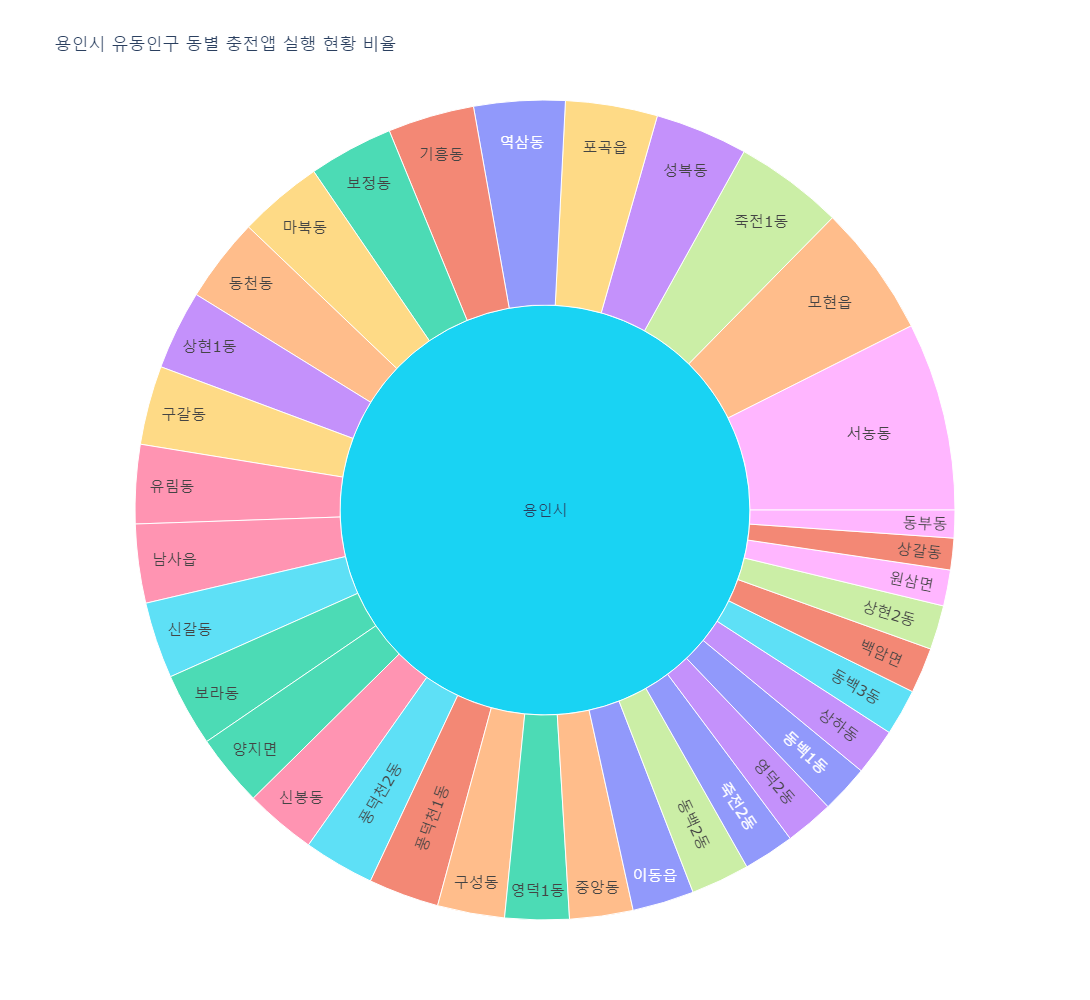

In [55]:
# 그룹2. 용인시 유동인구에서 동별 충전앱 실행 현황 비율
fig = px.sunburst(df_sum[df_sum.group == 2], path=['시군구명','행정동명'], color='행정동명', values = '실행자수',
                  title='용인시 유동인구 동별 충전앱 실행 현황 비율', height = 1000, width = 800)

fig.update_traces(textfont_size = 15)
fig.show()

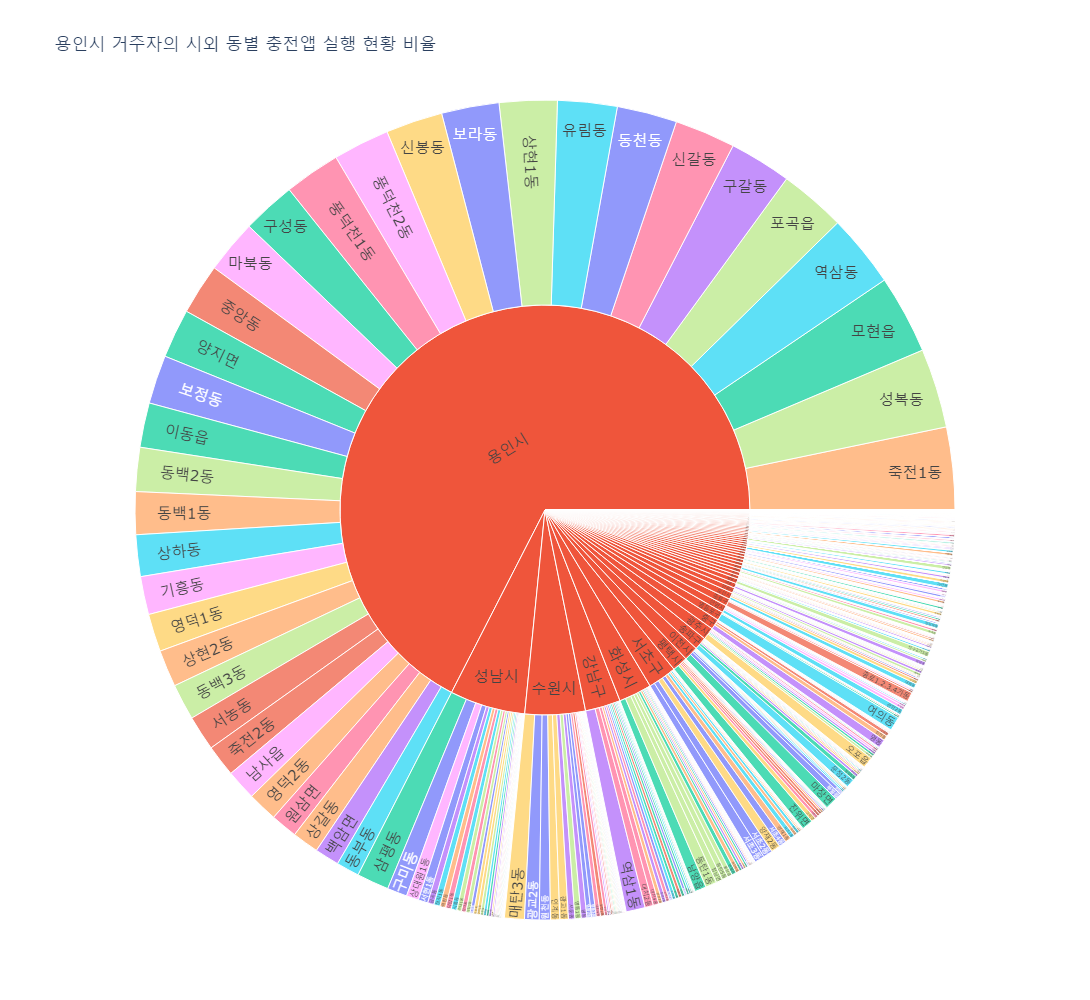

In [56]:
# 그룹3. 용인시 거주자의 시외 동별 충전앱 실행 현황 비율
fig = px.sunburst(df_sum[df_sum.group == 3], path=['시군구명','행정동명'], color='행정동명', values = '실행자수',
                  title='용인시 거주자의 시외 동별 충전앱 실행 현황 비율', height = 1000, width = 800)

fig.update_traces(textfont_size = 15)
fig.show()

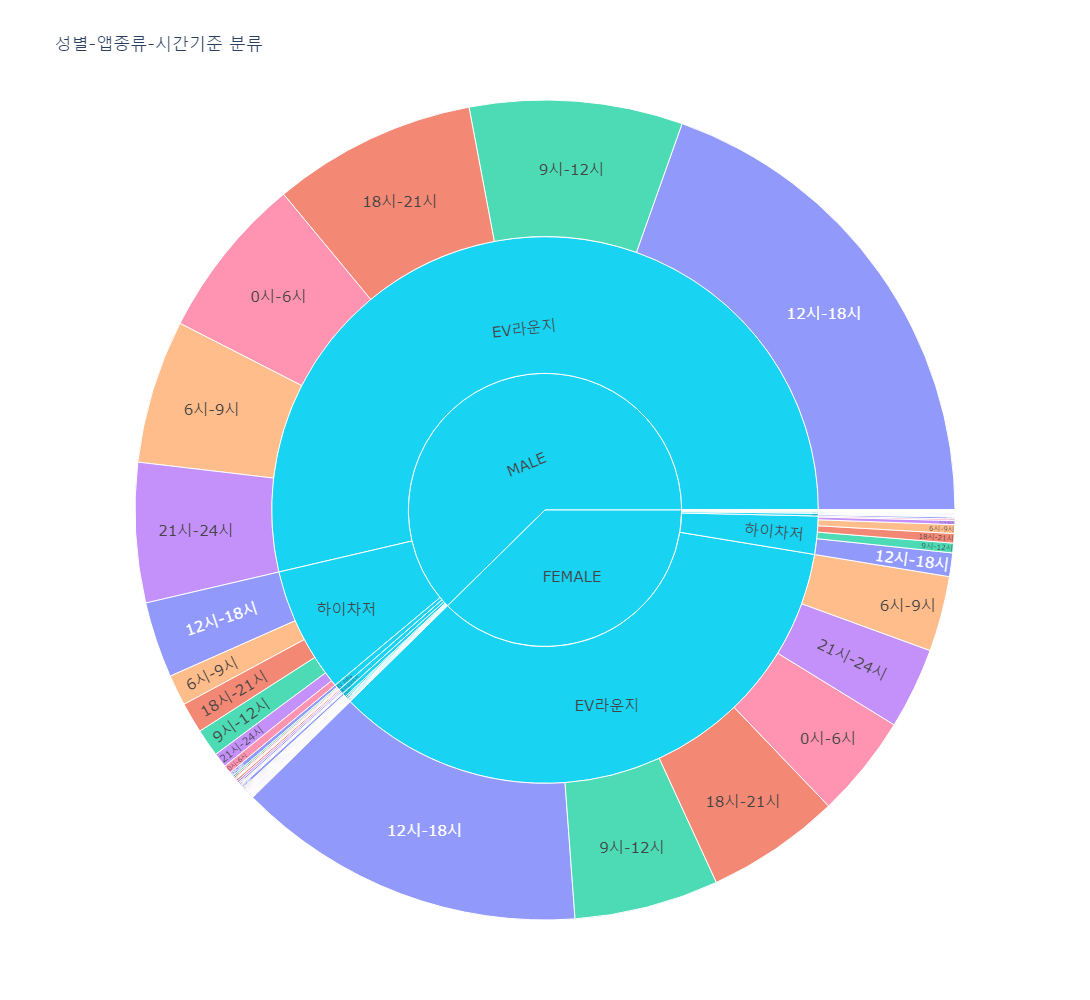

In [87]:
# 전체 성별 충전앱 실행 현황 비율
fig = px.sunburst(df_sum, path=['성별','앱종류','앱실행시간대'], color='앱실행시간대', values = '실행자수',
                  title='성별-앱종류-시간기준 분류', height = 1000, width = 800)

fig.update_traces(textfont_size = 15)
fig.show()

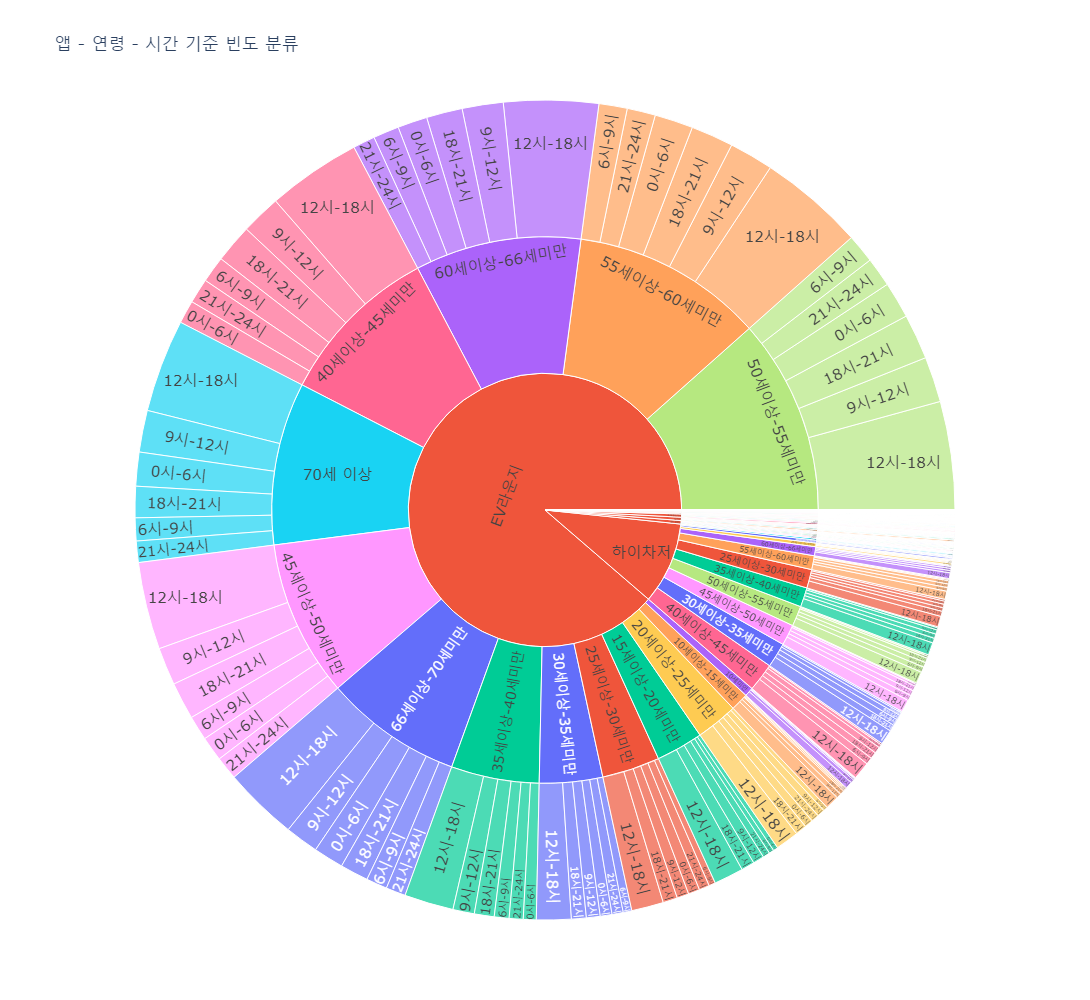

In [88]:
# 전체 연령 충전앱 실행 현황 비율
fig = px.sunburst(df_sum, path=['앱종류','연령','앱실행시간대'], color='연령', values = '실행자수',
                  title='앱 - 연령 - 시간 기준 빈도 분류', height = 1000, width = 800)

fig.update_traces(textfont_size = 15)
fig.show()

In [59]:
df_sum.head(3)

기준일자 요일  시도명 시군구명  행정동명         경도         위도      성별             연령  \
0  20220605  일  경기도  용인시  동백1동  127.15225  37.286300    MALE   30세이상-35세미만    
1  20220625  토  경기도  용인시  상현2동  127.09008  37.309536    MALE   40세이상-45세미만    
2  20220614  화  경기도  용인시   포곡읍  127.21660  37.274303  FEMALE        70세 이상    

      앱종류   앱실행시간대  실행자수  group  
0   EV라운지  18시-21시     3      1  
1  파워큐브차저    6시-9시     4      1  
2   EV라운지    0시-6시    18      1

In [60]:
df_sum['실행자수'].describe()

count    849927.000000
mean          6.125277
std           4.474234
min           3.000000
25%           3.000000
50%           4.000000
75%           8.000000
max         177.000000
Name: 실행자수, dtype: float64

In [61]:
# 성별, 연령은 낮은 가중치
# 완속충전은 급속에 비해 요금의 이점이 있음.
# 급속충전은 완속에 비해 시간적 이점이 있음.
# 앱종류는 EV라운지가 압도적이나 전기차 커뮤니티앱으로 충전소위치파악 및 커뮤니티이용을 위해 사용하는 것으로 판단됨 직접적인 충전결제등과는 무관함.
# 현대 하이차저의 경우 충전소 위치, 충전예약, 충전결제 등을 위해 사용.

In [62]:
# 각 그룹의 일별 행정동 실행자수의 최소최대값 , 평균값, 사분위수 산출
df_sqrt = df_sum.groupby(['group','기준일자','행정동명'])['실행자수'].describe()
df_sqrt

count       mean       std  min  25%  50%   75%   max
group 기준일자     행정동명                                                       
1     20220601 구갈동   456.0   5.109649  3.233247  3.0  3.0  3.0   6.0  21.0
               구성동   353.0   5.770538  3.849592  3.0  3.0  4.0   7.0  26.0
               기흥동   143.0   5.972028  4.090429  3.0  3.0  4.0   8.0  27.0
               남사읍   150.0   5.660000  3.301068  3.0  3.0  4.0   7.0  19.0
               동백1동  298.0   5.399329  3.750412  3.0  3.0  3.0   7.0  22.0
...                    ...        ...       ...  ...  ...  ...   ...   ...
3     20220630 화서2동    1.0   3.000000       NaN  3.0  3.0  3.0   3.0   3.0
               화수2동    2.0   5.000000  2.828427  3.0  4.0  5.0   6.0   7.0
               화양동     7.0  11.000000  6.633250  4.0  6.5  8.0  15.0  22.0
               화정1동    3.0   3.000000  0.000000  3.0  3.0  3.0   3.0   3.0
               회현동    26.0   5.000000  3.346640  3.0  4.0  4.0   4.0  20.0

[16070 rows x 8 columns]

In [63]:
# 리셋인덱스, 컬럼명 재수정
df_sqrt = df_sqrt.reset_index()
df_sqrt.columns = ['group', '기준일자', '행정동명', '카운트', '평균', '편차', '최소', '25%', '50%', '75%', '최대']
df_sqrt.head()

group      기준일자  행정동명    카운트        평균        편차   최소  25%  50%  75%    최대
0      1  20220601   구갈동  456.0  5.109649  3.233247  3.0  3.0  3.0  6.0  21.0
1      1  20220601   구성동  353.0  5.770538  3.849592  3.0  3.0  4.0  7.0  26.0
2      1  20220601   기흥동  143.0  5.972028  4.090429  3.0  3.0  4.0  8.0  27.0
3      1  20220601   남사읍  150.0  5.660000  3.301068  3.0  3.0  4.0  7.0  19.0
4      1  20220601  동백1동  298.0  5.399329  3.750412  3.0  3.0  3.0  7.0  22.0

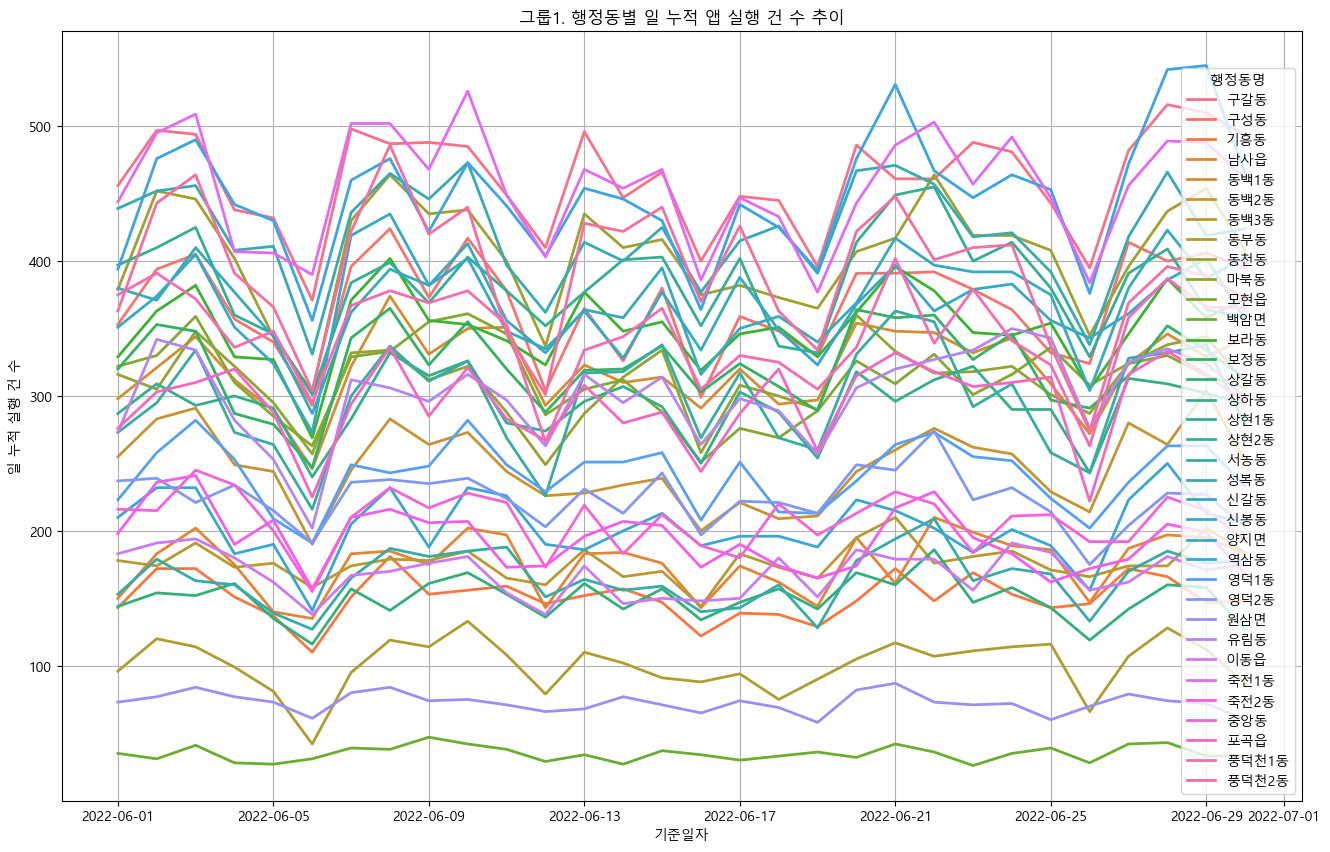

In [116]:
sns.lineplot(data=df_sqrt.query('group == 1'), x = '기준일자', y = '카운트', hue= '행정동명')
plt.title('그룹1. 행정동별 일 누적 앱 실행 건 수 추이')
plt.ylabel('일 누적 실행 건 수')
plt.show()

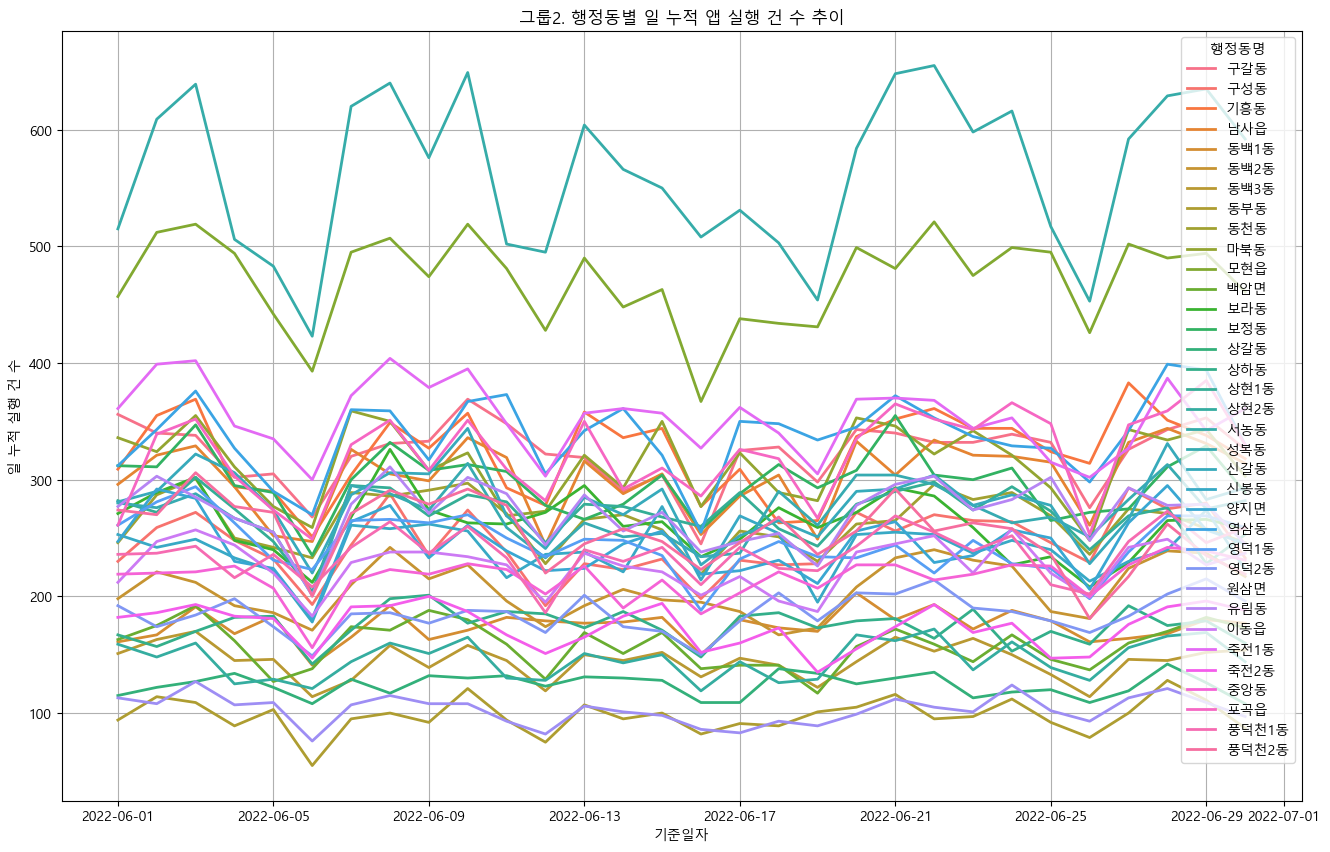

In [118]:
sns.lineplot(data=df_sqrt.query('group == 2'), x = '기준일자', y = '카운트', hue= '행정동명')
plt.title('그룹2. 행정동별 일 누적 앱 실행 건 수 추이')
plt.ylabel('일 누적 실행 건 수')
plt.show()

In [117]:
# 3번그룹은 동이 많아 하지않음.

In [91]:
df_sqrt.기준일자 = df_sqrt.기준일자.astype(str)

In [92]:
df_sqrt.기준일자 = pd.to_datetime(df_sqrt.기준일자, infer_datetime_format=True)

In [93]:
# 각 일자, 지역별 최소 3회에서 최대 177회까지 실행됨
df_sqrt.최소.min(), df_sqrt.최대.max()

(3.0, 177.0)

In [94]:
# 각 일자, 지역별 평균 실행횟수
df_sqrt.평균.min(), df_sqrt.평균.max()

(3.0, 23.0)

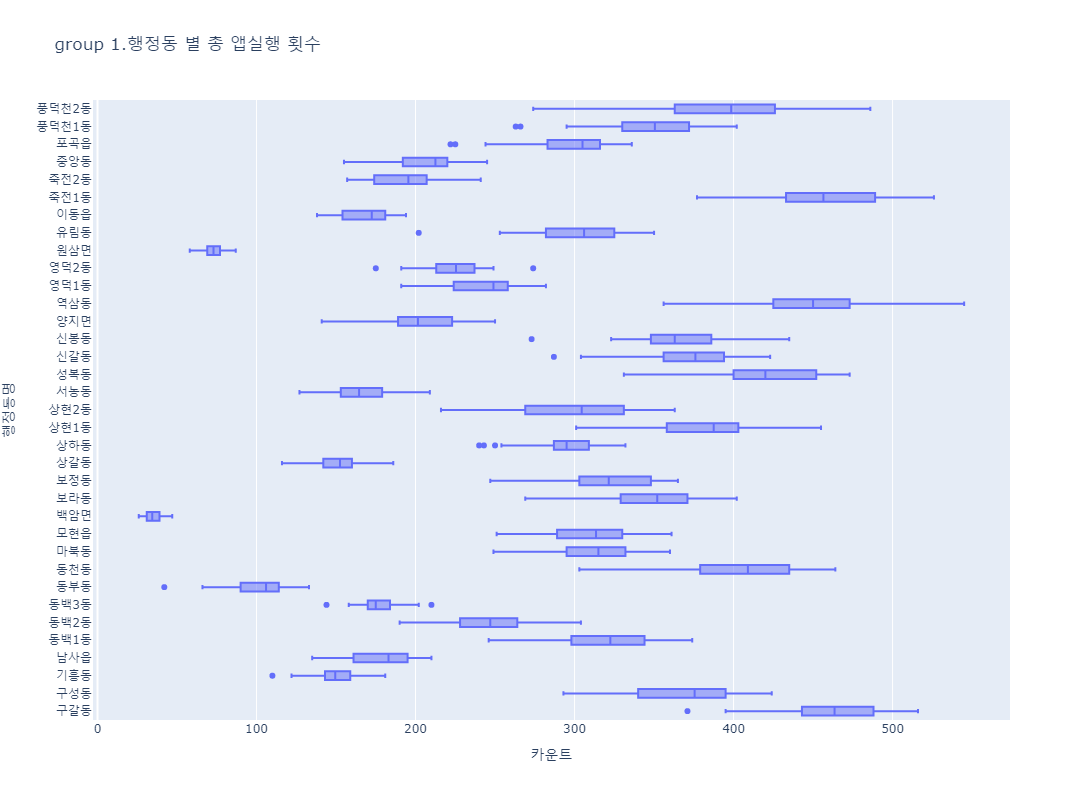

In [102]:
# 행정동별 총 사용횟수
# 부분 이상치 확인됨
px.box(df_sqrt[df_sqrt.group == 1], x = '카운트', y = '행정동명', height = 800, title = 'group 1.행정동 별 총 앱실행 횟수')

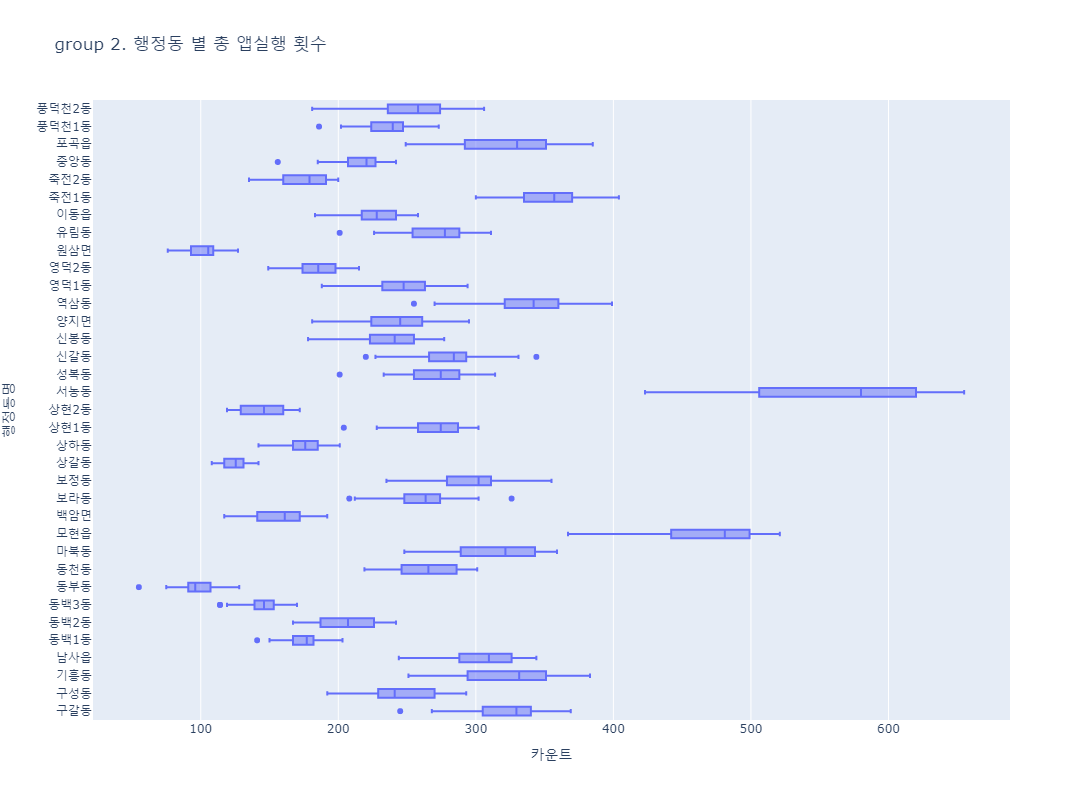

In [103]:
# 행정동별 총 사용횟수
# 부분 이상치 확인됨
px.box(df_sqrt[df_sqrt.group == 2], x = '카운트', y = '행정동명', height = 800, title = 'group 2. 행정동 별 총 앱실행 횟수')

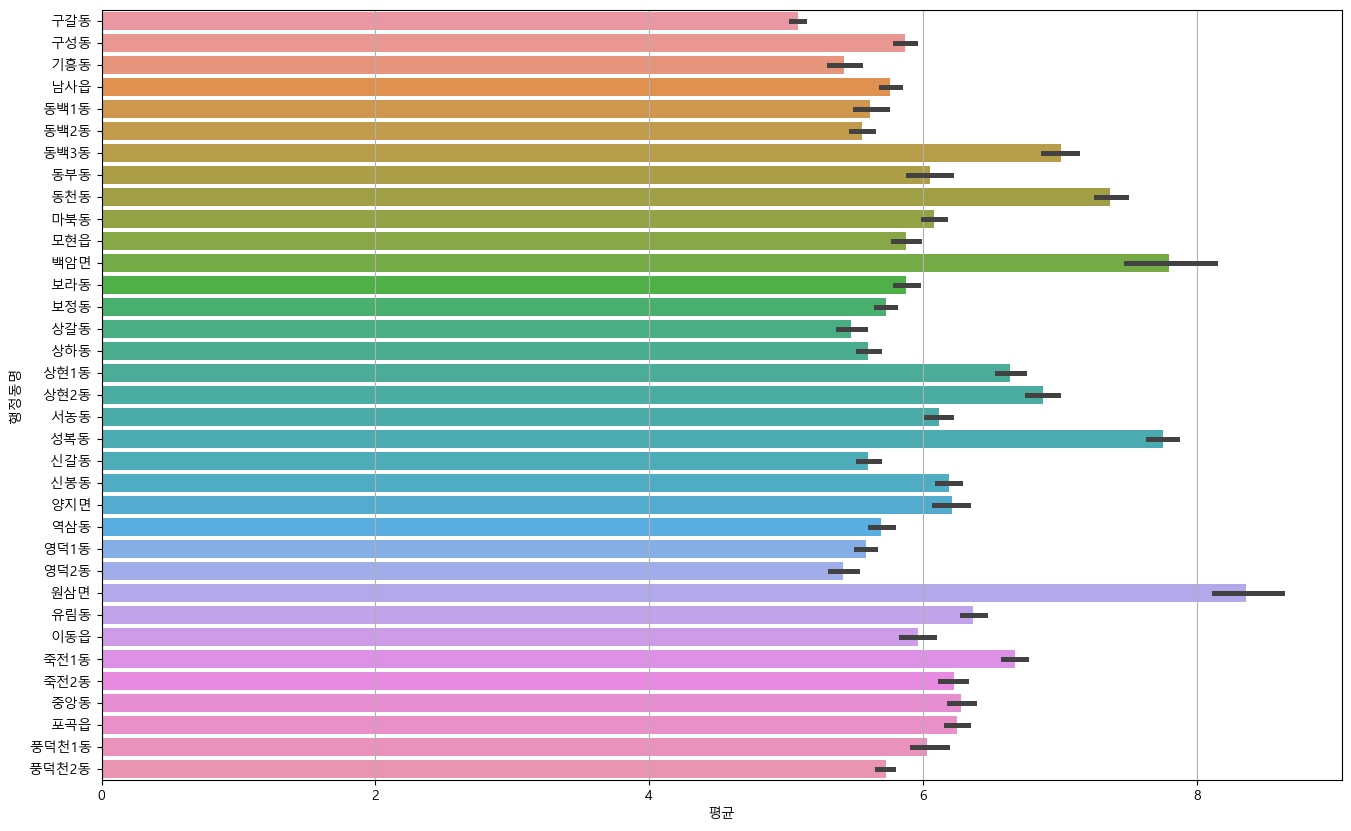

In [90]:
sns.barplot(df_sqrt[df_sqrt.group == 1], y = '행정동명', x = '평균')
plt.show()

In [74]:
# 3은 위치변수가 너무 많아 통합하여 표기
# sns.barplot(df_sqrt[df_sqrt.group == 3], y = '행정동명', x = '평균')
# plt.show()

In [73]:
df_sqrt.to_csv('./data/파생data/df_sqrt.csv')
df_sum.to_csv('./data/파생data/df_sum.csv')